# Projecting Food Insecurity Rates in the US by County
## Final Models and 2020 Predictions
### Flatiron School Data Science Capstone<br>By Khyatee Desai

This notebook contains the final Random Forest model used to make predictions on labeled data, as well as the Linear Regression model used to make predictions on unlabeled data, which projects 2020 food insecurity rates.<br>**The full modeling process can be reviewed in [modeling_process.ipynb](modeling_process.ipynb).**

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statistics as stats
import scipy.stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import sklearn
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pickle
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
warnings.filterwarnings('ignore')
import sys
sys.path.insert(0, '../src/')
from functions import *

### Import cleaned dataset

In [2]:
with open('../pickled/feature_engineered_data.pickle', "rb") as input_file:
    df = pickle.load(input_file) 
    
# remove features not needed for modeling
df.drop([ 'coc_number','Low Threshold Type', 'High Threshold Type',
       'State', 'County', 'State/County'],axis=1, inplace=True)
df.head(3)

,FIPS,Rent,Year,Houseless_rate,Sheltered_rate,Unsheltered_rate,hh_med_income,percent_hh_poverty,hh_avg_size,num_hh,TOT_POP,FI Rate,Cost Per Meal,Num_wholesale,Num_restaraunts,Num_grocery,Total_workforce,Employed,Unemployed,Unemployment_rate,Percent_male,Percent_female,Percent_white,Percent_Black,Percent_native,Percent_asian,Percent_pacific,Percent_latinX,Percent_PoC,Percent_working,Total_food_retail,Food_retail_per_person,Percent_disabled,Percent_hs_grad,Percent_bachelors,Percent_grad_degree,Percent_priv_health,Percent_public_health,Percent_no_health,Percent_65+,Percent_non_citizen,Percent_hh_no_vehicle,Percent_hh_SNAP,Rent^2,Rent^3,Houseless_rate^2,Houseless_rate^3,Sheltered_rate^2,Sheltered_rate^3,Unsheltered_rate^2,Unsheltered_rate^3,TOT_POP^2,TOT_POP^3,Cost Per Meal^2,Cost Per Meal^3,Num_wholesale^2,Num_wholesale^3,Num_restaraunts^2,Num_restaraunts^3,Num_grocery^2,Num_grocery^3,Unemployment_rate^2,Unemployment_rate^3,Percent_male^2,Percent_male^3,Percent_female^2,Percent_female^3,Percent_white^2,Percent_white^3,Percent_Black^2,Percent_Black^3,Percent_native^2,Percent_native^3,Percent_asian^2,Percent_asian^3,Percent_pacific^2,Percent_pacific^3,Percent_latinX^2,Percent_latinX^3,Percent_working^2,Percent_working^3,Total_food_retail^2,Total_food_retail^3,Food_retail_per_person^2,Food_retail_per_person^3,Percent_disabled^2,Percent_disabled^3,Percent_hs_grad^2,Percent_hs_grad^3,Percent_bachelors^2,Percent_bachelors^3,Percent_grad_degree^2,Percent_grad_degree^3,Percent_priv_health^2,Percent_priv_health^3,Percent_public_health^2,Percent_public_health^3,Percent_no_health^2,Percent_no_health^3,Percent_65+^2,Percent_65+^3,Percent_non_citizen^2,Percent_non_citizen^3,Percent_hh_no_vehicle^2,Percent_hh_no_vehicle^3,Percent_hh_SNAP^2,Percent_hh_SNAP^3,percent_hh_poverty^2,percent_hh_poverty^3,hh_avg_size^2,hh_avg_size^3,num_hh^2,num_hh^3,hh_med_income^2,hh_med_income^3,Unemployment_rate_X_Percent_Black,Unemployment_rate_X_Percent_white,Unemployment_rate_X_Percent_latinX,Houseless_rate_X_Sheltered_rate,Sheltered_rate_X_Percent_grad_degree,Percent_Black_X_Percent_hh_SNAP,Percent_latinX_X_hh_med_income,Cost Per Meal_X_Percent_Black,Unemployment_rate_X_hh_avg_size,Percent_white_X_Percent_hh_SNAP,Rent_X_Unemployment_rate,Percent_Black_X_Percent_grad_degree,Percent_pacific_X_Percent_hs_grad,Percent_latinX_X_Percent_hh_SNAP,Unemployment_rate_X_Percent_non_citizen,Percent_white_X_Percent_grad_degree,Percent_latinX_X_percent_hh_poverty,TOT_POP_X_Percent_latinX,Unemployment_rate_X_Percent_female,Unemployment_rate_X_Percent_male,Percent_pacific_X_Percent_public_health,Percent_Black_X_Percent_hs_grad,Percent_latinX_X_num_hh,Rent_X_Percent_Black,Num_grocery_X_num_hh,Houseless_rate_X_Percent_pacific,Percent_white_X_percent_hh_poverty,Percent_white_X_Percent_priv_health,Percent_white_X_Percent_pacific,Unemployment_rate_X_Percent_hs_grad,Unemployment_rate_X_Percent_disabled,Percent_white_X_Percent_no_health,Percent_female_X_Percent_hs_grad,Sheltered_rate_X_Percent_working,Percent_Black_X_Percent_no_health,Percent_Black_X_percent_hh_poverty,Percent_pacific_X_Percent_disabled,Cost Per Meal_X_Percent_white,Percent_pacific_X_Percent_65+,Sheltered_rate_X_Percent_no_health,TOT_POP_X_Num_grocery,Percent_Black_X_hh_med_income,Percent_Black_X_Percent_priv_health,Percent_hs_grad_X_hh_avg_size,Sheltered_rate_X_Percent_pacific,Unemployment_rate_X_Percent_hh_SNAP,Percent_latinX_X_Percent_priv_health,Total_food_retail_X_num_hh,Houseless_rate_X_Percent_grad_degree,Percent_pacific_X_Percent_hh_SNAP,log_Rent,log_Houseless_rate,log_Sheltered_rate,log_Unsheltered_rate,log_TOT_POP,log_Cost Per Meal,log_Num_wholesale,log_Num_restaraunts,log_Num_grocery,log_Unemployment_rate,log_Percent_male,log_Percent_female,log_Percent_white,log_Percent_Black,log_Percent_native,log_Percent_asian,log_Percent_pacific,log_Percent_latinX,log_Percent_working,log_Total_food_retail,log_Food_retail_per_person,log_Percent_disabled,log_Percent_hs_grad,log_Percent_bachelors,log_Percent_grad_degree,l

### Import RFE Features
The best features were generated using Recursive Feature Elimination in the [modeling process notebook](modeling_process.ipynb). They are imported here using Pickle:

In [3]:
with open('../pickled/rfe_features.pickle', "rb") as input_file:
    rfe_features = pickle.load(input_file) 
  

### Train/Test Split
Define training data from 2010-2018 sets

In [4]:
# subset dataframe and drop null values
df_model = df[df.Year.isin(['2010','2011','2012','2013','2014','2015','2016','2017',
                    '2018'])].dropna(subset=['Num_wholesale','Percent_disabled','Houseless_rate','hh_med_income'])
for col in df_model.columns:
    if 'Rent' in col:
        df_model.drop(col,axis=1,inplace=True)
        
# isolate target variable and features
y = df_model['FI Rate']
X = df_model.drop(['FIPS', 'FI Rate','Year'],axis=1)

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Random Forest Regressor
The Random Forest Regressor was shown to produce the best results in the modeling notebook, when predicting on labeled data. It was saved using Pickle, and is imported here:
### Import pickled model and make predictions

In [5]:
with open('../pickled/random_forest_model.pickle', "rb") as input_file:
    forest_model = pickle.load(input_file) 

# make predictions on the train/test sets
y_train_pred = forest_model.predict(X_train[rfe_features])
y_test_pred = forest_model.predict(X_test[rfe_features])


# Final Model Evaluation
The final random forest model performed with an average Train/Test R2 of **0.97**, an average Train/Test RMSE of **0.007**, and a cross validation RMSE of **0.139**

In [16]:
# R2 of training and test set
print('R2 Train:', forest_model.score(X_train[rfe_features], y_train))
print('R2 Test:', forest_model.score(X_test[rfe_features], y_test))

# RMSE of training and test set
print('RMSE Train:',np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE Test:',np.sqrt(mean_squared_error(y_test, y_test_pred)),'\n')

# # cross validation scores
# scores = cross_val_score(forest_model, X[rfe_features], y, cv=5,  scoring='neg_root_mean_squared_error')
# print('CV Scores:',scores)
# print('Mean CV Score:', abs(np.mean(scores)))

R2 Train: 0.9738061966945791
R2 Test: 0.972561642197964
RMSE Train: 0.00691061759408623
RMSE Test: 0.007117661567133555 

CV Scores: [-0.01333501 -0.01282055 -0.01558319 -0.01707373 -0.01077681]
Mean CV Score: 0.013917857650896998


## Random Forest Feature Importance
interpret feature importance here:

In [6]:
sorted(list(zip(forest_model.feature_importances_,rfe_features)),reverse=True)[:10]

[(0.17831721238295917, 'percent_hh_poverty^3'),
 (0.152009986741346, 'percent_hh_poverty^2'),
 (0.13583949969233422, 'Unemployment_rate_X_Percent_Black'),
 (0.12191952201812248, 'log_percent_hh_poverty'),
 (0.12094327794092337, 'percent_hh_poverty'),
 (0.03795736853318411, 'Unemployment_rate_X_Percent_disabled'),
 (0.02307712042000854, 'Cost Per Meal_X_Percent_white'),
 (0.014823089523174729, 'Percent_Black_X_percent_hh_poverty'),
 (0.012267910957547984, 'hh_med_income'),
 (0.011747707890496218, 'log_hh_med_income')]

## Generate Predictions
The following cells make predictions on all 2018 data, using the best RFE model, and then visualize these predicitons in a choropleth map alongside the actual FI values for 2018.

In [6]:
# Create dataframe for just 2018
df_18 = df[df.Year.isin(['2018'])].dropna(subset=['Num_wholesale','Percent_disabled','Houseless_rate','hh_med_income'])
for col in df_18.columns:
    if 'Rent' in col:
        df_18.drop(col,axis=1,inplace=True)
        
# separate target and features
y = df_18['FI Rate']
X = df_18.drop(['FIPS', 'FI Rate','Year'],axis=1)


Make predictions and inspect preds vs actual values side-by-side

In [7]:
# Use RFE model to predict on all 2018 data, and create new column in dataframe for predictions
preds_2018 = forest_model.predict(X[rfe_features])
        
df_preds = pd.concat([df_18.reset_index() ,pd.Series(preds_2018)],axis=1,).rename(columns={0:'Predicted FI Rate'})
df_preds[['FI Rate','Predicted FI Rate']].sample(10)


,FI Rate,Predicted FI Rate
3035,0.132,0.136520
970,0.108,0.110953
599,0.081,0.085835
1755,0.157,0.155760
1419,0.105,0.106518
610,0.084,0.086490
1901,0.169,0.178568
2923,0.131,0.127643
516,0.146,0.146285
2935,0.116,0.115575


## Map the Predictions
The choropleth maps below indicate that the model performs very well and is able to capture most of the variance within the data, especially in places which are the most significantly impacted. The model falls slightly short on capturing the severity of food insecurity rates in some areas, such as Texas.

White areas are counties which contained missing values, due to a lack of food retail data in some counties for the year 2018. Dropping these columns altogether caused model performance to decrease noticeably, therefore they were retained, and null rows were dropped instead.

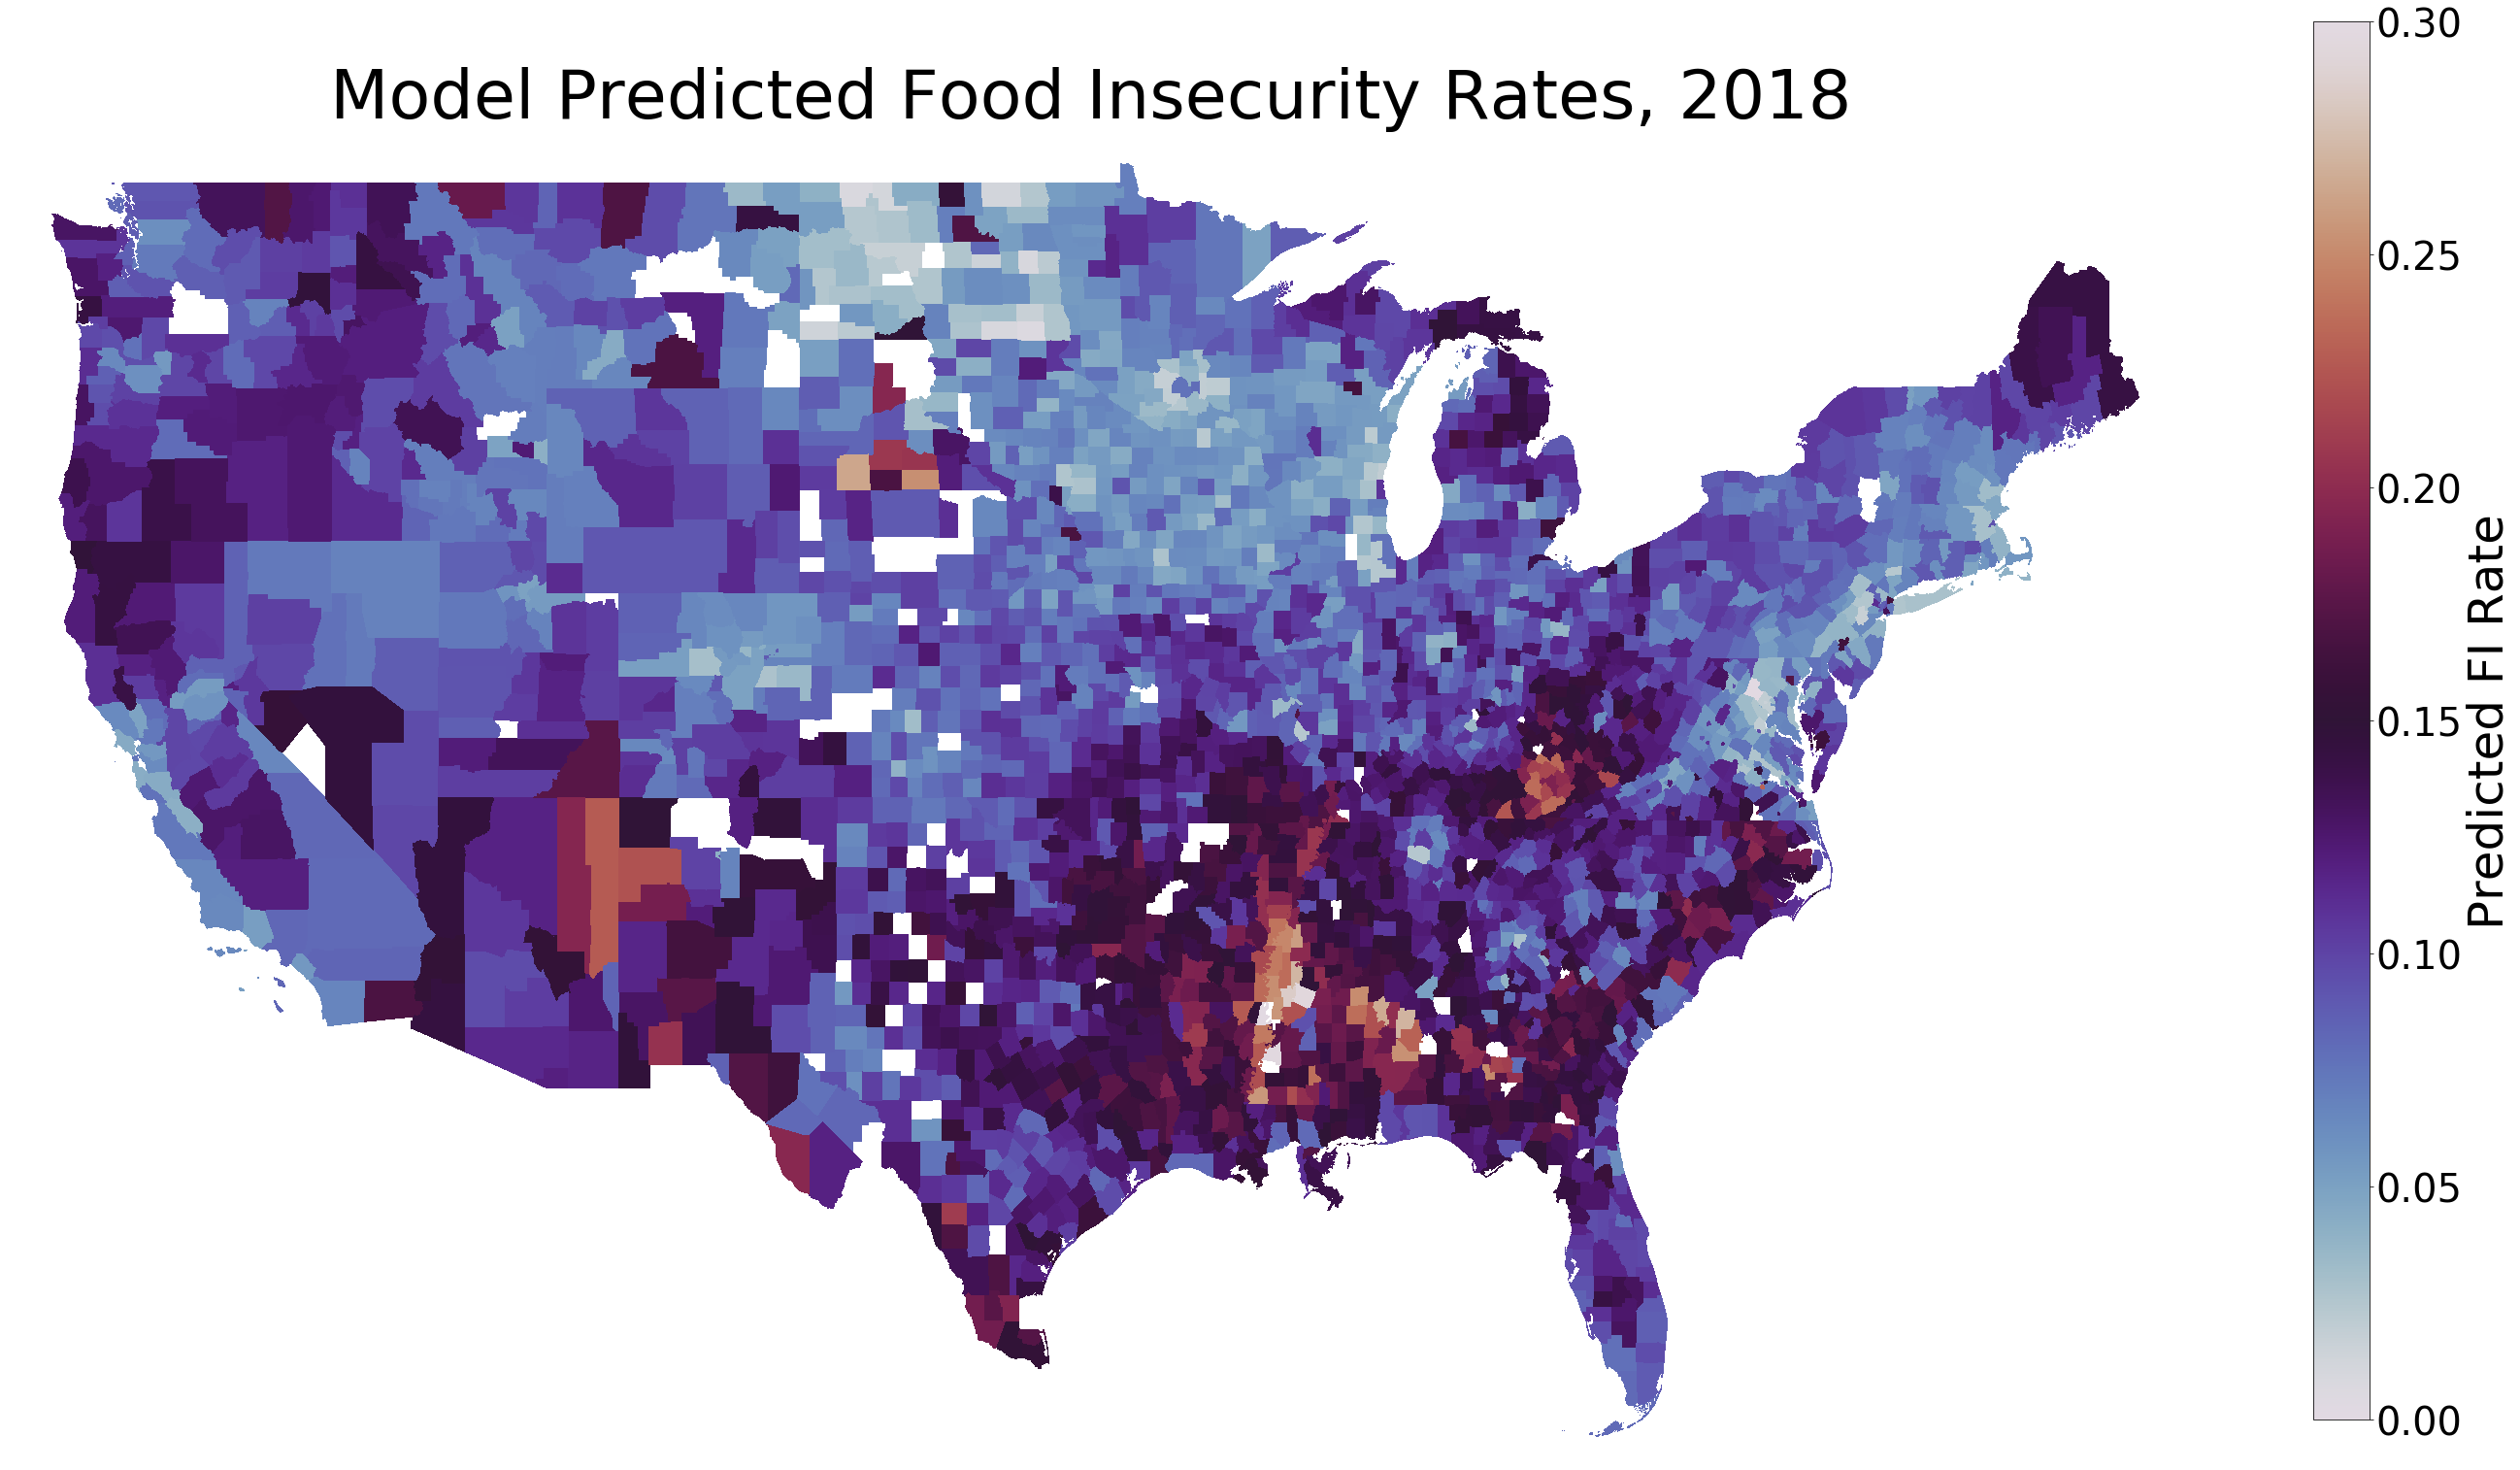

In [8]:
# Map the predictions alongside actual FI rates
choropleth(df_preds,'Predicted FI Rate',['2018'],'twilight','Model Predicted Food Insecurity Rates')
# choropleth(df_preds,'FI Rate',['2018'],'twilight', 'Actual Food Insecurity Rates')

# Unlabeled 2020 Predictions
To generate predictions for 2020 FI rates, the model is trained on data from years 2010-2018, and is limited to the features that are available for 2020 data -- this excludes Houselessness, Food Retail, Number of Households, Vehicle Access, SNAP Benefits, and more. After the model is trained on labeled data, it is used to make predictions for 2020 food insecurity rates. 
### Drop polynomial features for regression model

In [8]:
# remove column names including "^" symbol, indicating a polynomial feature
no_poly_cols = df.columns[~df.columns.str.contains('^', regex=False)]
df = df[no_poly_cols]


### Drop columns that do not exist in 2020 dataset

In [9]:
df_model = df[df.Year.isin(['2010','2011','2012','2013','2014','2015','2016','2017','2018'])]

for col in df_model.columns:
    if 'Rent' in col:
        df_model.drop(col,axis=1,inplace=True)
    if 'Houseless' in col:
        df_model.drop(col,axis=1,inplace=True)
    if 'heltered' in col:
        try:
            df_model.drop(col,axis=1,inplace=True)
        except:
            pass
    if 'poverty' in col:
        df_model.drop(col,axis=1,inplace=True)
    if 'TOT_POP' in col:
        df_model.drop(col,axis=1,inplace=True)
    if 'Cost Per Meal' in col:
        df_model.drop(col,axis=1,inplace=True)
    if 'wholesale' in col:
        df_model.drop(col,axis=1,inplace=True)
    if 'restaraunt' in col:
        df_model.drop(col,axis=1,inplace=True)
    if 'num_hh'in col:
        df_model.drop(col,axis=1,inplace=True)
    if 'grocery' in col:
        try:
            df_model.drop(col,axis=1,inplace=True)
        except:
            pass
    if 'working' in col:
        try:
            df_model.drop(col,axis=1,inplace=True)
        except:
            pass
    if 'retail' in col:
        try:
            df_model.drop(col,axis=1,inplace=True)
        except:
            pass
    if '65+' in col:
        df_model.drop(col,axis=1,inplace=True)
    if 'vehicle' in col:
        df_model.drop(col,axis=1,inplace=True)
    if 'SNAP' in col:
        df_model.drop(col,axis=1,inplace=True)

# Create dataframe for just 2018
df_model.dropna(subset=['Percent_no_health','Total_workforce','hh_med_income', 'FI Rate'],inplace=True)


### Train/Test Split the trimmed data

In [10]:
# separate target and features
y = df_model['FI Rate']
X = df_model.drop(['FIPS', 'FI Rate','Year'],axis=1)

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Perform RFE on training set

In [11]:
linreg = LinearRegression()
selector = RFECV(estimator= linreg, step=1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
selector.fit(X_train, y_train)
rfe_features = X_train.columns[selector.support_]

## Linear Regression Model
Linear regression is used with RFE features to make 2020 predictions, because it was found to perform more consistently than the other models after removing features such as Houselessness, Food Retail, Number of Households, Vehicle Access, and SNAP Benefits.
### Train and Evaluate the Model
The 2020 Linear Regression Model performs with an average Train/Test R2 of **0.846**, an average Train/Test RMSE of **0.165**, and a cross validation RMSE of **0.81**. This is reduced performance due to the dropped features, but still reasonable to make predictions with.

In [12]:
# instantiate the model and make predictions
linreg_2020 = LinearRegression()
linreg_2020.fit(X_train[rfe_features], y_train)
y_train_pred = linreg_2020.predict(X_train[rfe_features])
y_test_pred = linreg_2020.predict(X_test[rfe_features])

# R2 of training and test set
print('R2 Train:', linreg_2020.score(X_train[rfe_features], y_train))
print('R2 Test:', linreg_2020.score(X_test[rfe_features], y_test))

# RMSE of training and test set
print('RMSE Train:',np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE Test:',np.sqrt(mean_squared_error(y_test, y_test_pred)),'\n')

# cross validation scores
scores =cross_val_score(linreg_2020, X[rfe_features], y, cv=5,  scoring='r2')
print('CV Scores:',scores)
print('Mean CV Score:',np.mean(scores))

R2 Train: 0.8459457050787502
R2 Test: 0.8464119760671682
RMSE Train: 0.016619407348249505
RMSE Test: 0.016150285377828987 

CV Scores: [0.86098133 0.77965441 0.83526708 0.67749829 0.89600047]
Mean CV Score: 0.8098803141953821


### Linear Regression Model Coeffients
While houselessness and food proximity were found to be deciding factors in the previous models that used all features, this model relies on **race**, **education**, **unemployment**, and **healthcare access** to model the data, as can be seen from the below feature importances.

In [13]:
sorted(list(zip(linreg_2020.coef_.tolist(), X_test.columns)), reverse=True)[:10]

[(0.9927909153593919, 'Percent_white_X_Percent_pacific'),
 (0.8005978890877465, 'Percent_pacific'),
 (0.5359286475030008, 'Percent_male'),
 (0.21044525136467024, 'log_Percent_female'),
 (0.18393575977251336, 'Percent_white_X_Percent_priv_health'),
 (0.1789862165357196, 'Percent_white_X_Percent_no_health'),
 (0.151278226778992, 'Percent_Black_X_Percent_priv_health'),
 (0.14197848078730654, 'Percent_public_health'),
 (0.13752805289416262, 'Percent_PoC'),
 (0.13056897225508704, 'Percent_hs_grad')]

## Predict on Unlabeled 2020 Data
Use the newly trained model to make predictions on the unlabeled data for 2020 food insecurity rates

In [14]:
df_20 = df[df.Year=='2020']
df_20.drop(['FI Rate'],axis=1,inplace=True)

for col in df_20.columns:
    if 'Rent' in col:
        df_20.drop(col,axis=1,inplace=True)
    if 'Houseless' in col:
        df_20.drop(col,axis=1,inplace=True)
    if 'heltered' in col:
        try:
            df_20.drop(col,axis=1,inplace=True)
        except:
            pass
    if 'poverty' in col:
        df_20.drop(col,axis=1,inplace=True)
    if 'TOT_POP' in col:
        df_20.drop(col,axis=1,inplace=True)
    if 'Cost Per Meal' in col:
        df_20.drop(col,axis=1,inplace=True)
    if 'wholesale' in col:
        df_20.drop(col,axis=1,inplace=True)
    if 'restaraunt' in col:
        df_20.drop(col,axis=1,inplace=True)
    if 'num_hh'in col:
        df_20.drop(col,axis=1,inplace=True)
    if 'grocery' in col:
        try:
            df_20.drop(col,axis=1,inplace=True)
        except:
            pass
    if 'working' in col:
        try:
            df_20.drop(col,axis=1,inplace=True)
        except:
            pass
    if 'retail' in col:
        try:
            df_20.drop(col,axis=1,inplace=True)
        except:
            pass
    if '65+' in col:
        df_20.drop(col,axis=1,inplace=True)
    if 'vehicle' in col:
        df_20.drop(col,axis=1,inplace=True)
    if 'SNAP' in col:
        df_20.drop(col,axis=1,inplace=True)

df_20.dropna(subset=['Percent_male','hh_avg_size','hh_med_income'],inplace=True)

### Make Predictions

In [15]:
# concat preds back into dataframe for mapping
preds_20 = linreg_2020.predict(df_20[rfe_features])
df_preds_20 = pd.concat([df_20.reset_index(), pd.Series(preds_20)],axis=1).rename(columns={0:'Pred FI Rate 2020'})


### Map Predictions

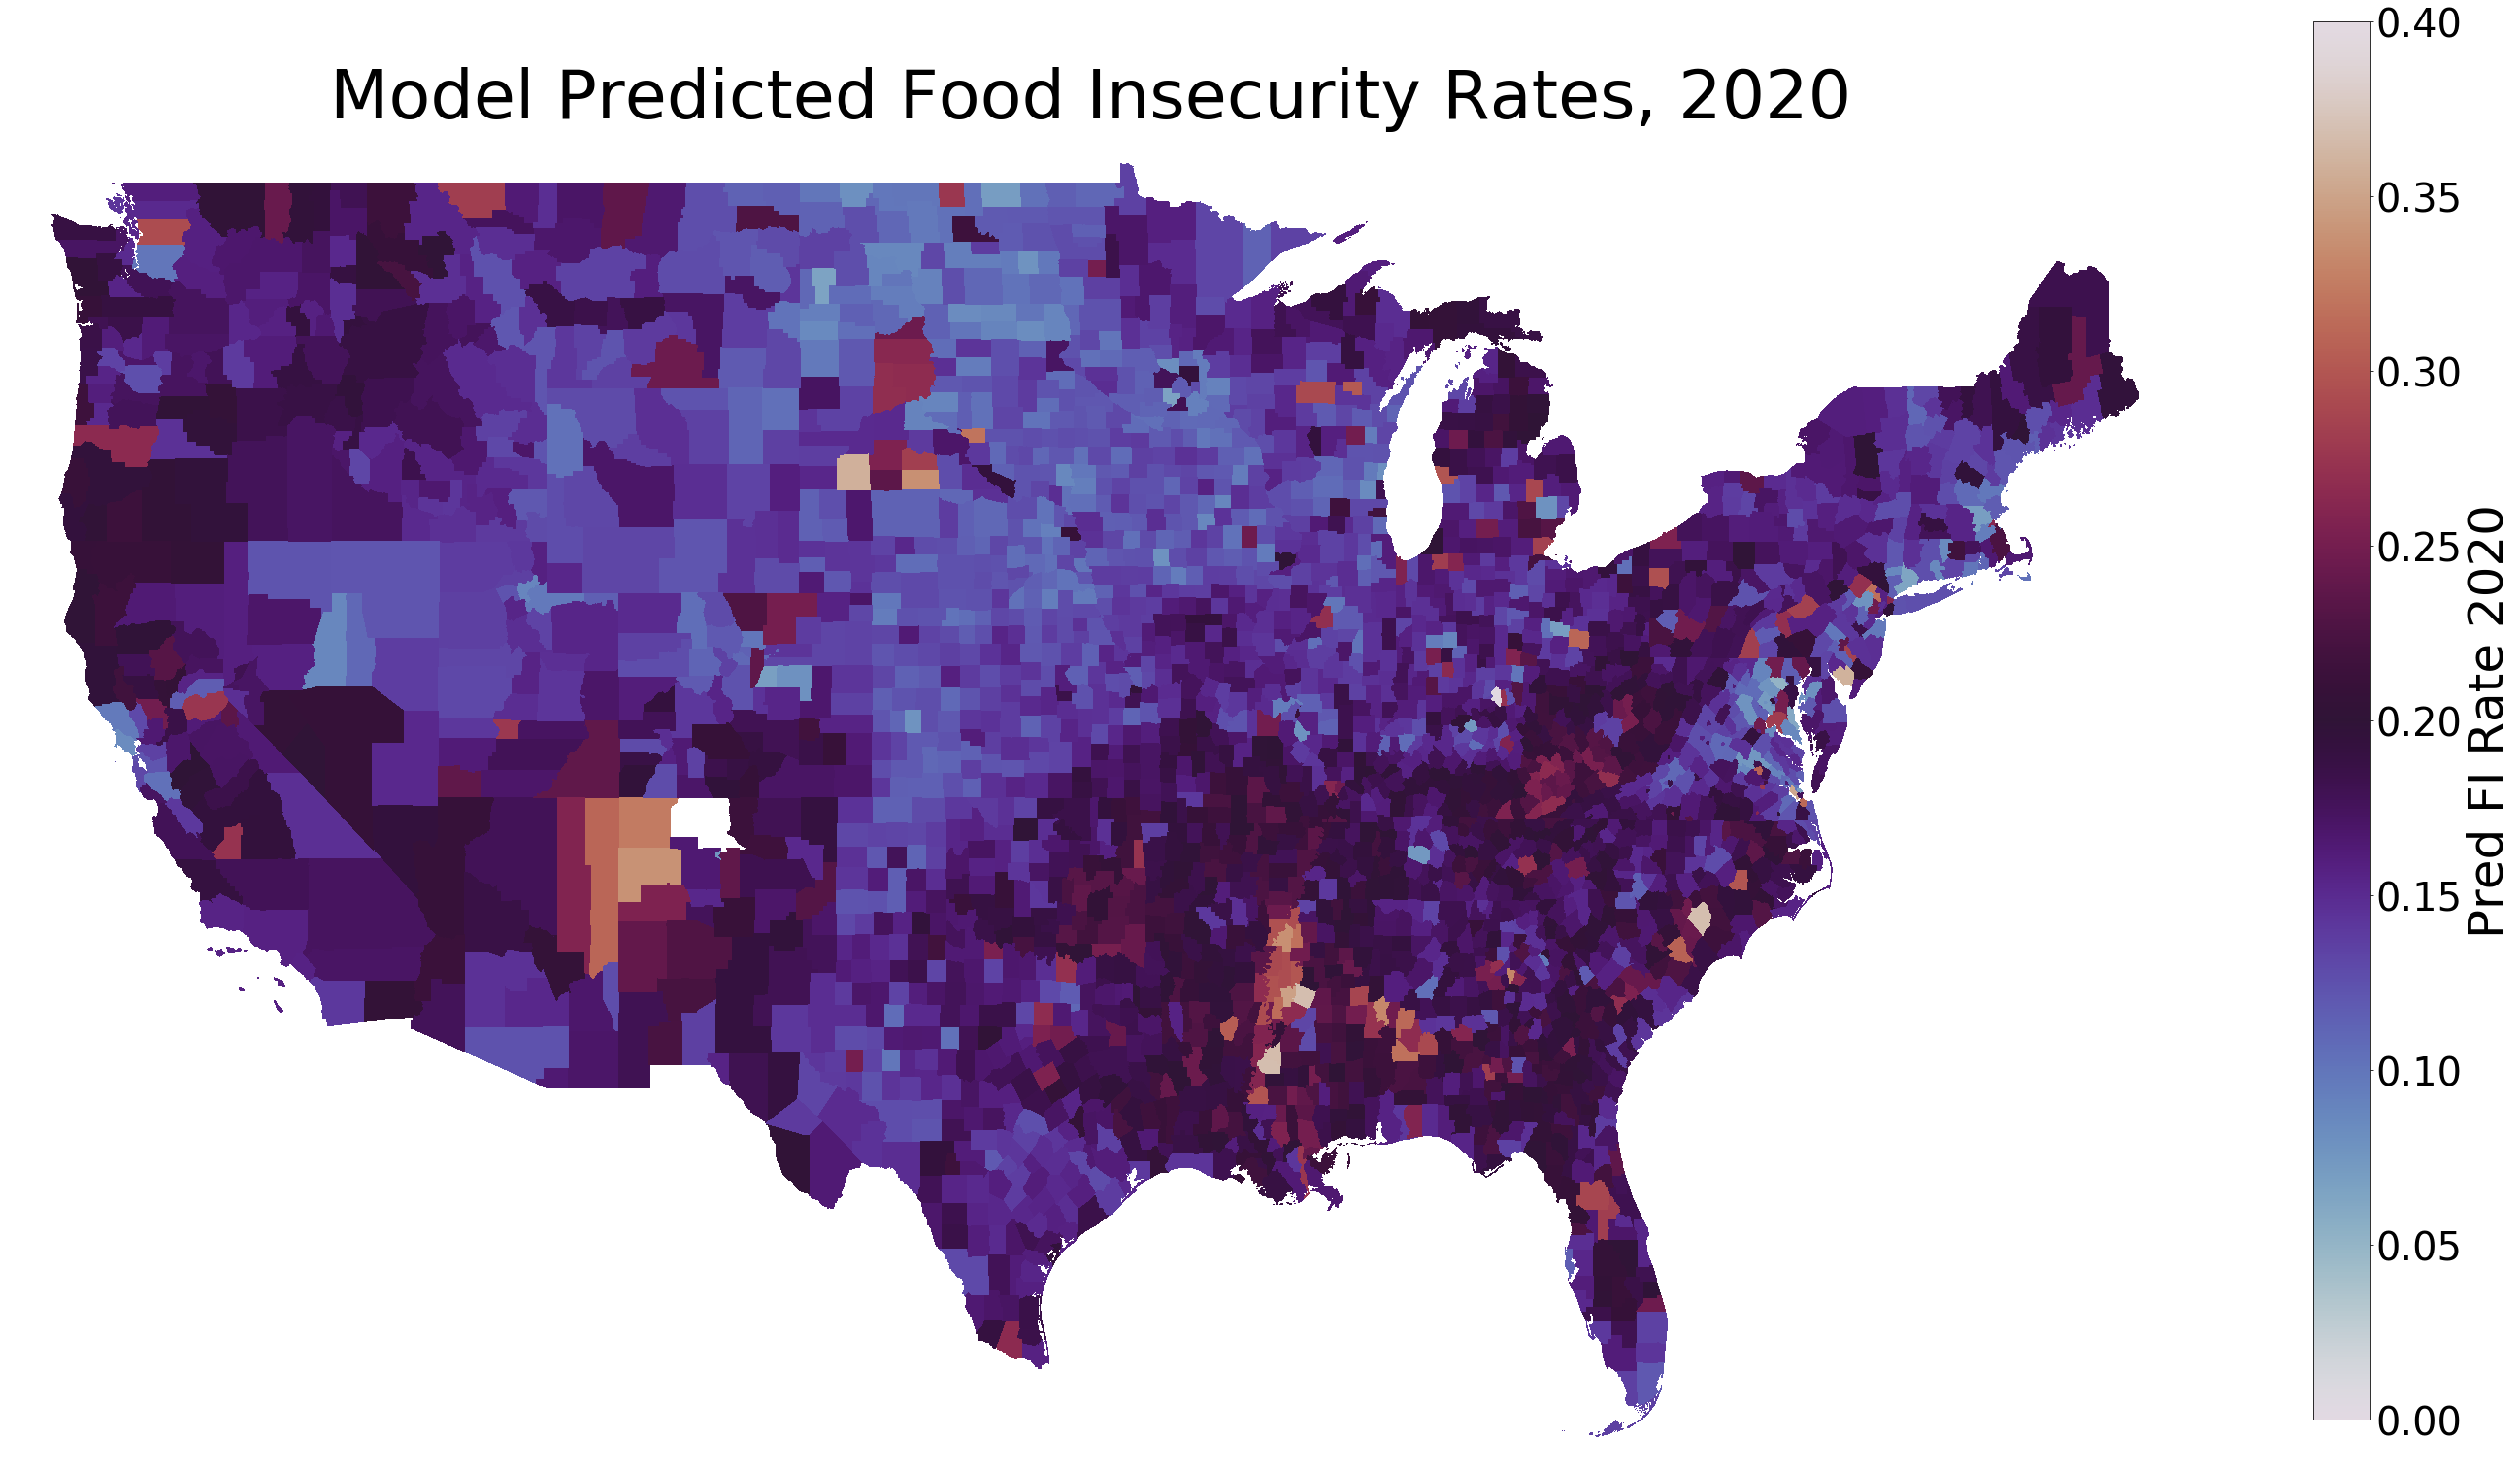

In [16]:
# linreg without polynomials, kept hs_grad rate
choropleth(df_preds_20,'Pred FI Rate 2020',['2020'],'twilight','Model Predicted Food Insecurity Rates')
# choropleth(df_18,'FI Rate',['2018'],'twilight', 'Actual Food Insecurity Rates')

## Feeding America's 2020 Projections
Feeding America generated predictions on 2020 food insecurity rates as part of their Covid19 study on hunger in america. To evaluate the performance of my model, I wanted to map my predictions alongside Feeding America's predictions to visually compare their similarity.

In [60]:
# import Feeding America's predictions
with open('../pickled/projection_20.pickle', "rb") as input_file:
    df_projected = pickle.load(input_file) 
df_projected

,FIPS,Total Population,FI Rate,Year
0,01001,55200,0.186,2020
1,01003,208107,0.163,2020
2,01005,25782,0.251,2020
3,01007,22527,0.189,2020
4,01009,57645,0.161,2020
...,...,...,...,...
3137,56037,44117,0.150,2020
3138,56039,23059,0.135,2020
3139,56041,20609,0.166,2020
3140,56043,8129,0.152,2020


### Visually compare the model
The Feeding America predictions appear to be very similar to 2018 actual FI rates, and display more variance between different parts of the country. My model predicts more severe food insecurity throughout the entire country, but particularly in the South and along the West Coast.

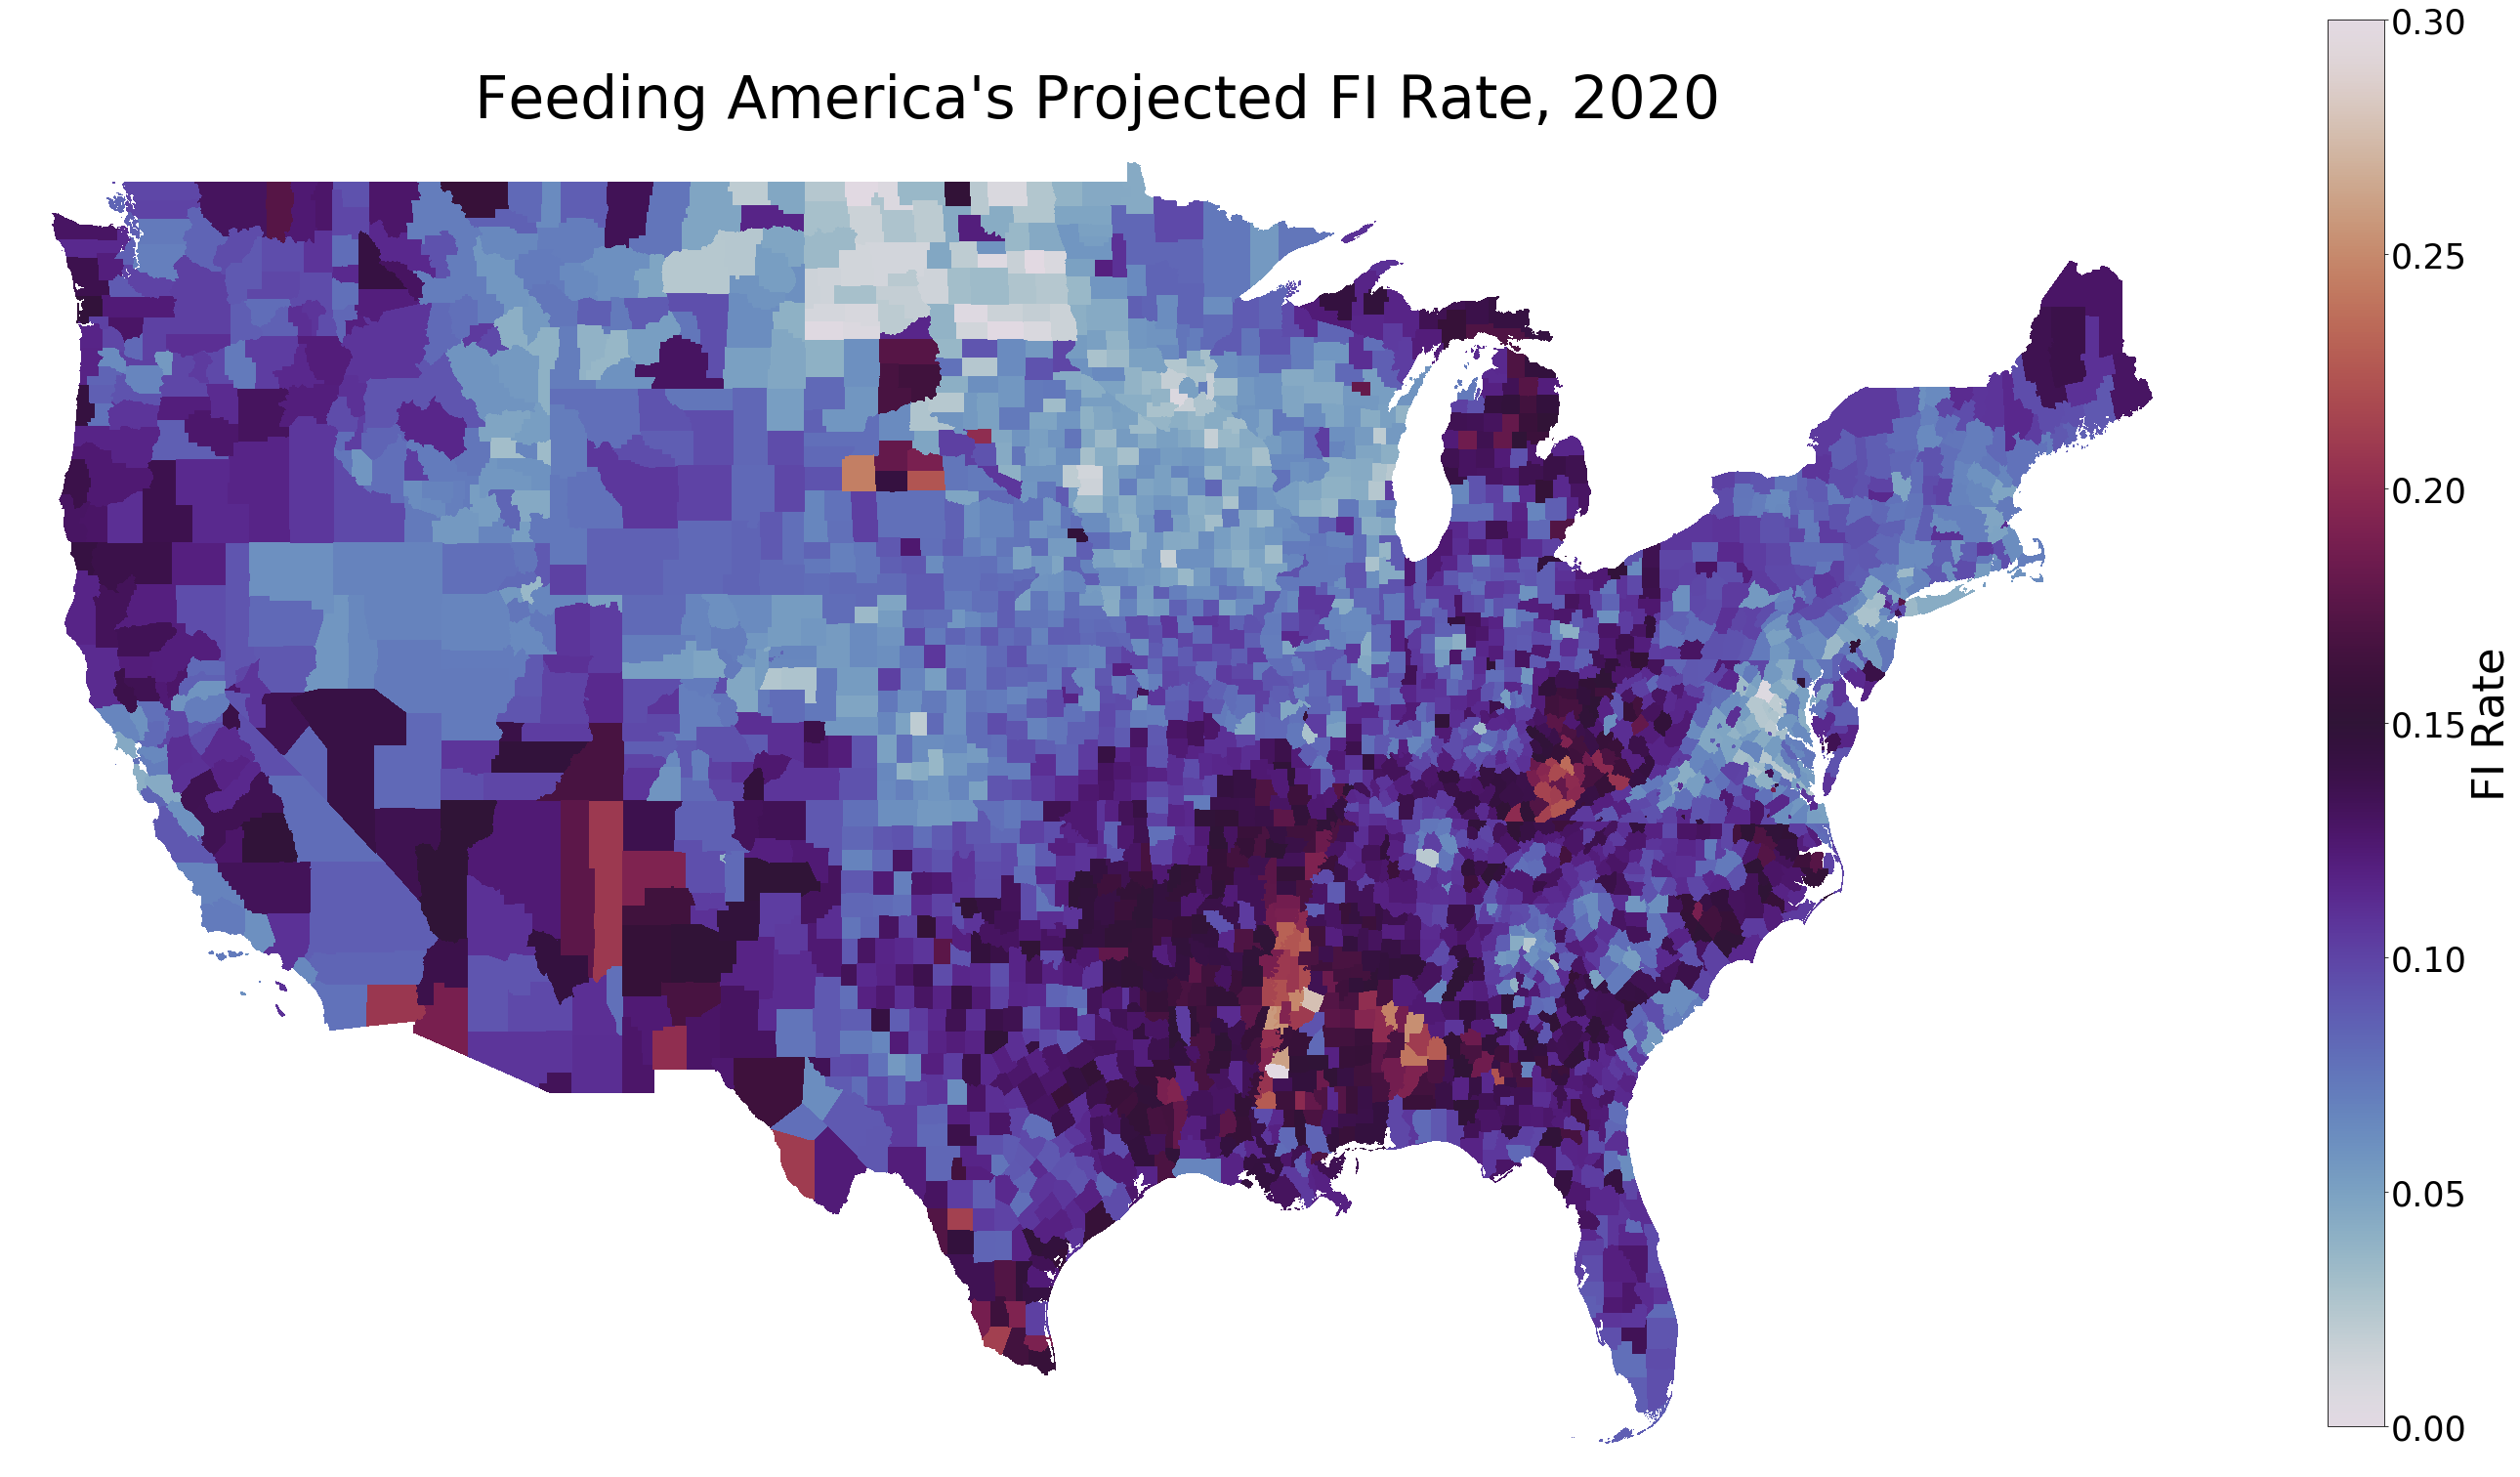

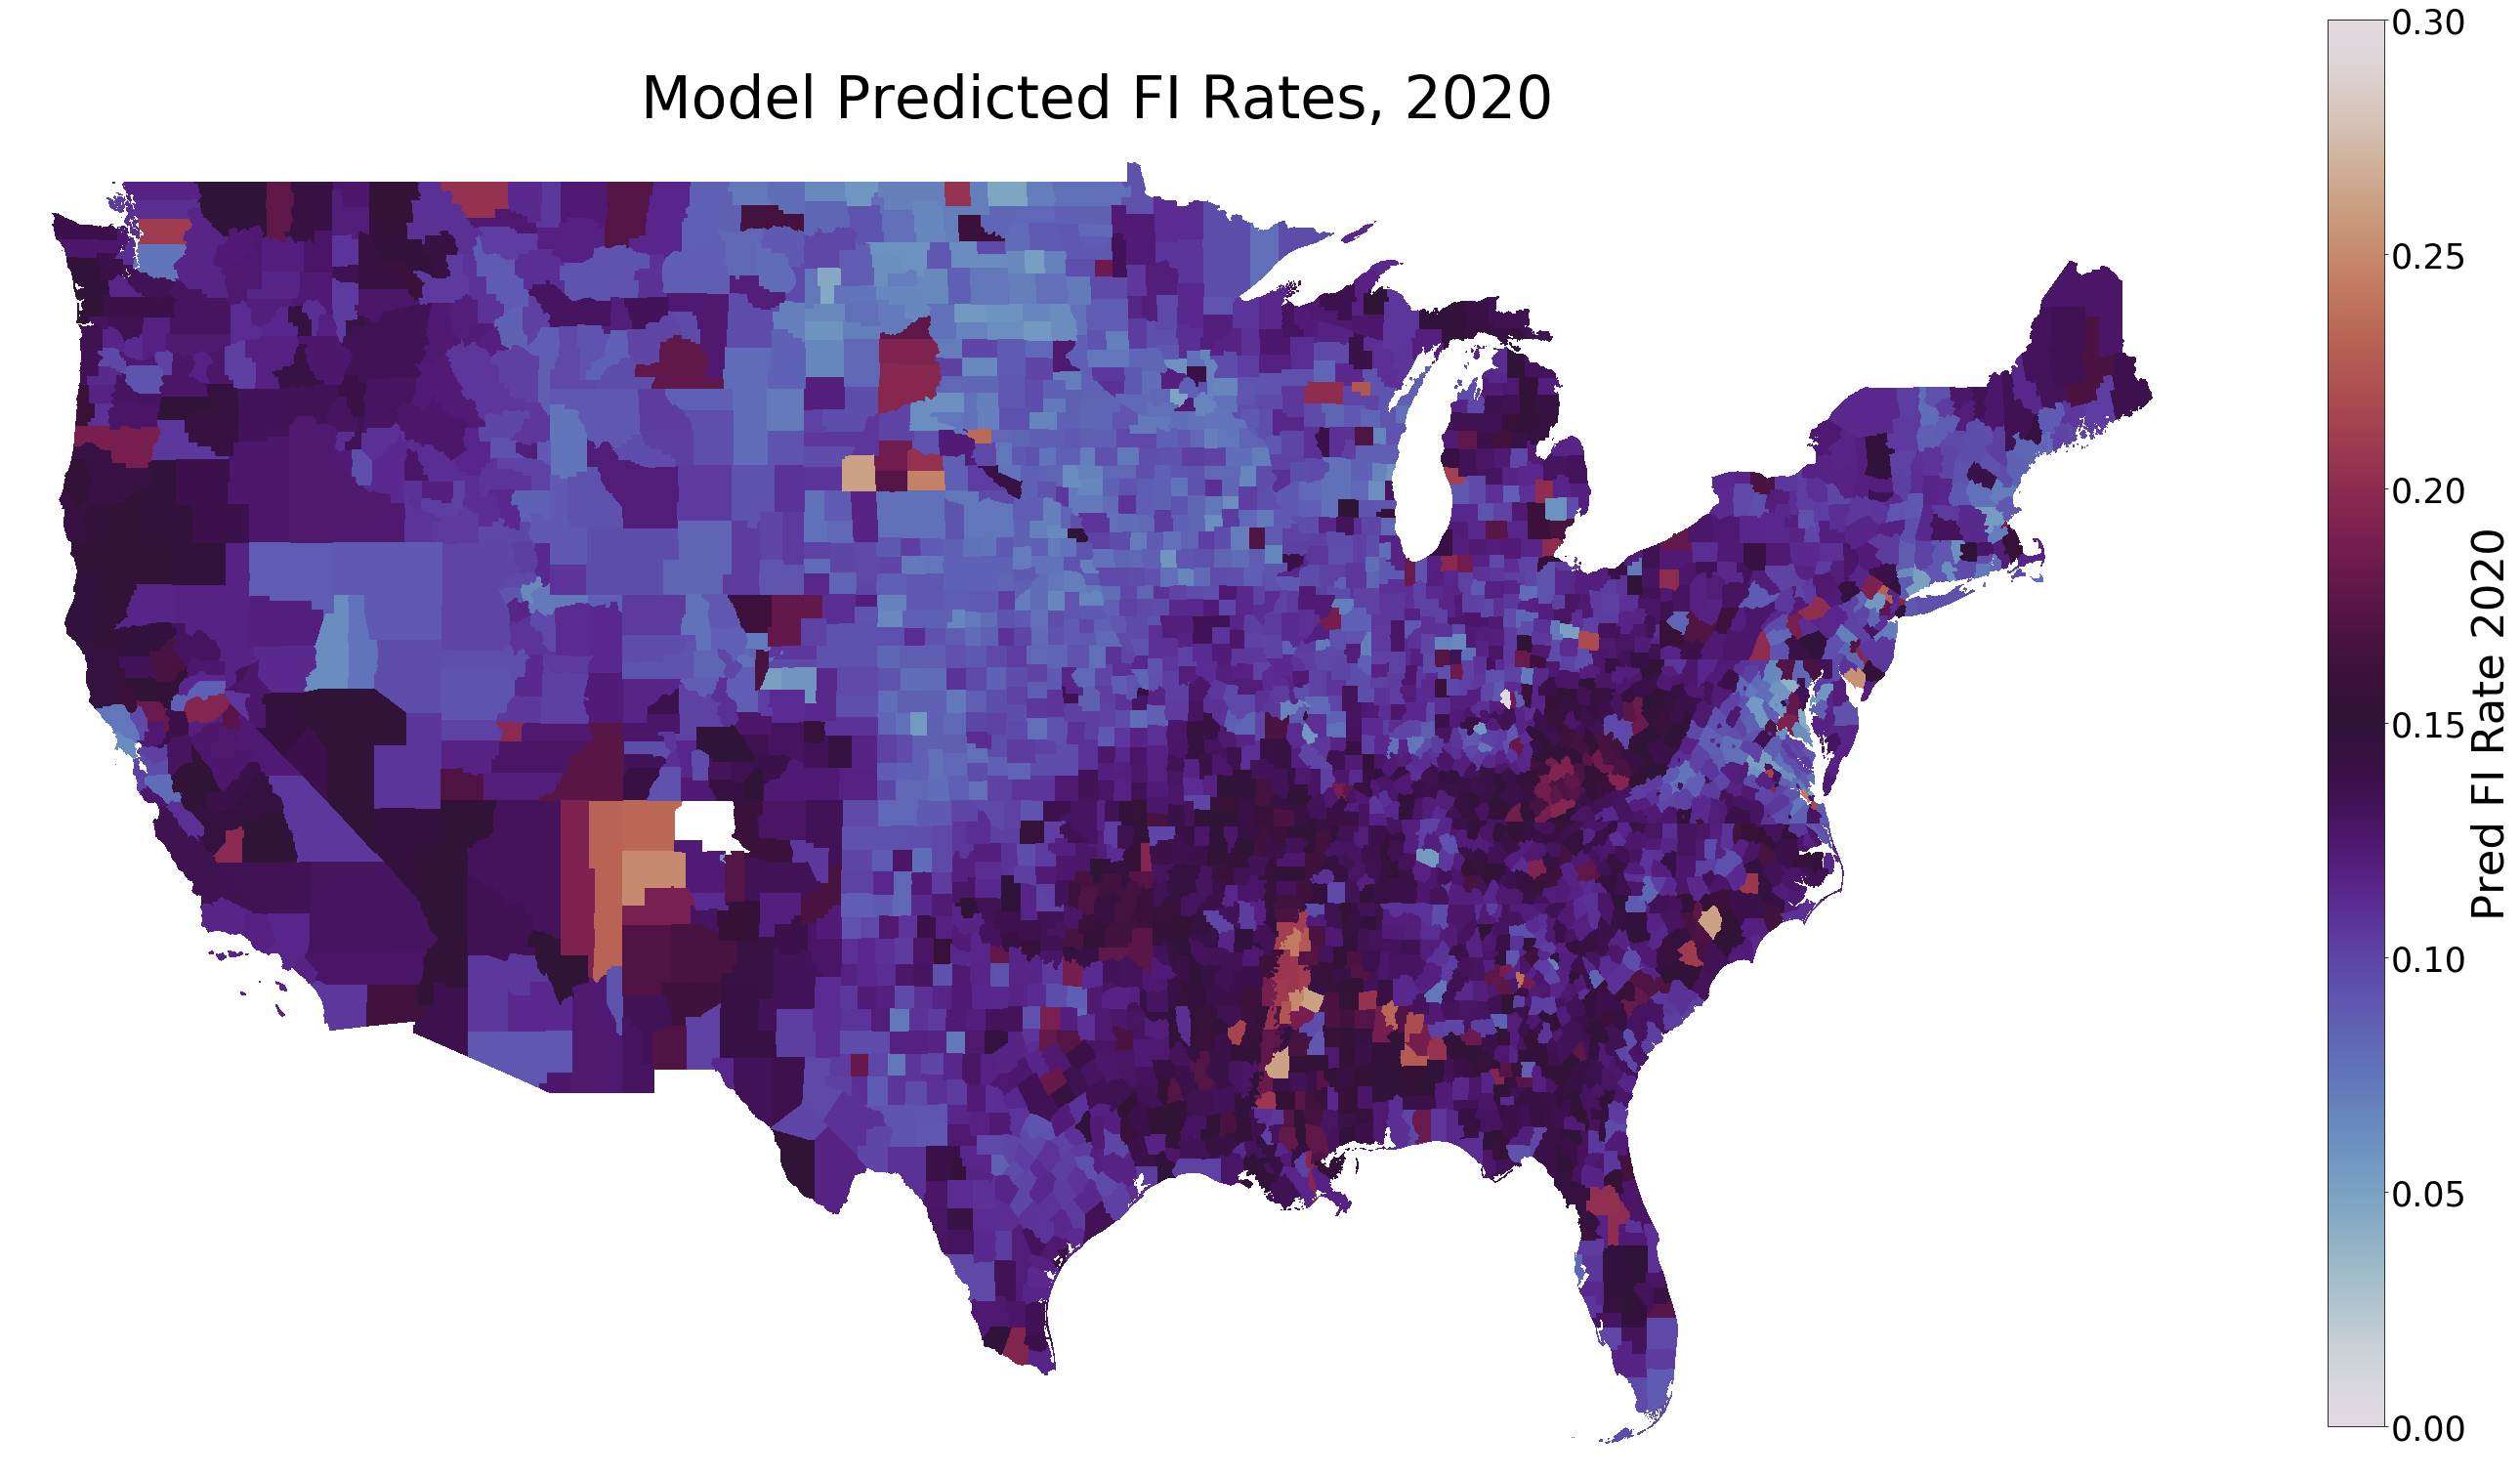

In [62]:
choropleth(df_projected,'FI Rate',['2020'],'twilight', "Feeding America's Projected FI Rate")
choropleth(df_preds_20,'Pred FI Rate 2020',['2020'],'twilight','Model Predicted FI Rates')

# Conclusion
The final RFE Random Forest Regressor was able to explain about **88%** of the variance in the data, based on a cross validation R2 score of **.884**, and was off on predictions by an average of **1.5%**, based on Test RMSE score of 0.015.<br> The most important features used in this model were shown to be `Unsheltered_rate_X_Percent_asian`, `Sheltered_rate_X_Percent_white`, `Sheltered_rate_X_Percent_Black`, `Houseless_rate_X_Percent_asian`, and `Unsheltered_rate_X_Percent_male`, based on model coefficients. 
<br>**This indicates that both houselessness and race play a critical role in determining the likelihood of food insecurity, but especially so when these features interact** (ie. someone who is both Black and houseless.)<br>  

The choropleth maps on 2018 FI Rate predictions indicate that the model was able to capture the general trend of food insecurity, particularly in places that are most impacted.